In [33]:
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import evaluate

In [ ]:

test_dataset_names = ["ISEAR", "DR", "Dreaddit", "SDCNL", "DepSeverity"]
data_path = ""
assert data_path != "", "Please update the proper data path"


token_path = ""
model_path = ""

assert model_path != "", "Please update the proper model path"

In [35]:
def _get_text_label_from_path(path):
    # Assuming that the dataset file is csv and contains `text` & `label` columns
    texts = []
    labels = []
    labels_set = set()
    with open(path, "r", encoding = "utf-8") as test_file:
        reader = csv.reader(test_file)
        text_id = 0
        label_id = 1
        for id, _row in enumerate(reader):
            if(id == 0 or len(_row) < 2):
                continue
            else:
                texts.append(_row[text_id])
                labels.append(label2id[_row[label_id]])
                labels_set.add(_row[label_id])
        test_file.close()
    assert (len(texts) == len(labels)), "Number of text {} is different from number of labels {}".format(len(texts), len(labels))
    return texts[:10], labels[:10]


In [36]:
def compute_metrics(preds, labels):
    accuracy_metric = evaluate.load("f1", trust_remote_code = True)
    precision_metric = evaluate.load("precision", trust_remote_code = True)
    recall_metric = evaluate.load("recall", trust_remote_code = True)

    accuracy = accuracy_metric.compute(predictions=preds, references=labels, average = 'weighted')
    precision = precision_metric.compute(predictions=preds, references=labels, average = 'weighted')
    recall = recall_metric.compute(predictions=preds, references=labels, average = 'weighted')
    return {**accuracy, **precision, **recall}

In [ ]:
from evaluate import evaluator
from evaluate import load, combine
import evaluate
import csv
import torch
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import evaluate

token = "" #Huggingface token to access the model
# Load model directly
tokenizer = AutoTokenizer.from_pretrained(token_path, token = token, model_max_length = 2048, truncation_side = "left")
new_model = AutoModelForSequenceClassification.from_pretrained(f"{model_path}") # Check the config.json for the proper name



# Currently hard code, it can yield error when access to model config of Lora fine-tuned
label2id = {'anger': 0, 'depression': 1, 'disgust': 2, 'fear': 3, 'guilt': 4, 'joy': 5, 'mild': 6, 'minimum': 7, 'moderate': 8, 'no': 9, 'sadness': 10, 'severe': 11, 'shame': 12, 'suicidal': 13, 'yes': 14}
print("Label2id", label2id)

new_model.eval()




for test_dataset_name in test_dataset_names:

    dataset = Dataset.from_csv(f"{data_path}/{test_dataset_name}.csv")
    dataset = dataset.map(lambda example: {"label": label2id[example["label"]], 'input_ids': tokenizer(example['text']).input_ids})

    task_evaluator = evaluator("text-classification")

    train_args = TrainingArguments(
        output_dir = "",
        do_train = False,
        do_eval = True,
        per_device_eval_batch_size = 1,
    )

    trainer = Trainer(
        model=new_model,
        args=train_args
    )

    results = trainer.predict(test_dataset = dataset)

    
    preds = results.predictions
    labels = results.label_ids

    preds = torch.from_numpy(preds)
    preds = torch.argmax(preds, dim = -1)

    
    labels = torch.from_numpy(labels)

    print(f"For dataset {test_dataset_name}, the results are: {compute_metrics(preds, labels)}")


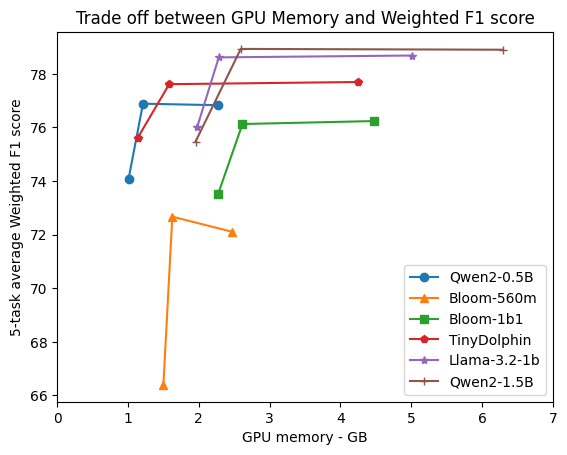

In [9]:
import matplotlib.pyplot as plt


data = {
    "Qwen2-0.5B"  : [[1.009, 1.213,	2.267], [74.0718,	76.886,	76.8296]],
    "Bloom-560m"  : [[1.501,	1.627,	2.463], [66.3918,	72.6704,	72.1126]],
    "Bloom-1b1"   : [[2.275,	2.617,	4.479], [73.529,	76.127,	76.2382]],
    "TinyDolphin" : [[1.139,	1.583,	4.247], [75.613,	77.614,	77.6956]],
    "Llama-3.2-1b": [[1.98,	2.283,	5.007], [76.0344,	78.614,	78.6834]],
    "Qwen2-1.5B"  : [[1.955,	2.593,	6.287], [75.4718,	78.9296,	78.8998]]
}


markers = {
    "Qwen2-0.5B"  : 'o',
    "Bloom-560m"  : '^',
    "Bloom-1b1"   : 's',
    "TinyDolphin" : 'p',
    "Llama-3.2-1b": '*',
    "Qwen2-1.5B"  : '+'
}

for model_name in data.keys():
    memory, accuracy = data[model_name]
    plt.plot(memory, accuracy, marker = markers[model_name], label = model_name)

plt.title("Trade off between GPU Memory and Weighted F1 score")
plt.xlabel("GPU memory - GB")
plt.ylabel("5-task average Weighted F1 score")
plt.xlim(0, 7)

plt.legend()
plt.show()
